This file demonstrates how the predictive model was created. It shows only a straight way to the resulting model. Tests of less efficient approaches and hyper parameter tuning steps are omitted.

In [1]:
import numpy as np
import pandas as pd
import pyarrow
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pwcal_hsa
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import dump


The training data containing results of 945 gene knockout/knockdown experiments was downloaded from ChEA3 website and preprocessed. This data set was earlier used for a similar purpose in *Nucleic Acids Res. 2019 Jul 2;47(W1):W212-W224. doi: 10.1093/nar/gkz446*. 

In [2]:
cases_df = pd.read_parquet('1000_perturbations.parquet')
# Keep only human-related entries
cases_df = cases_df[cases_df['species']=='hsa']
cases_df

,species,case,degs,degs_entrez
5,hsa,RARA,"[WSB2, SP110, MX1, SLC12A2, KRT8, PPA1, MALL, ...","[55884, 3431, 4599, 6558, 3856, 5464, 7851, 63..."
7,hsa,MYB,"[CDK19, WSB1, MED4, ZNF281, ZFYVE21, TM4SF1, C...","[23097, 26118, 29079, 23528, 79038, 4071, 5574..."
9,hsa,ZNF207,"[ZNF165, ANKEF1, GOLPH3L, RFX2, ZFYVE26, ST5, ...","[7718, 63926, 55204, 101928900, 23503, 6764, 6..."
10,hsa,SOX2,"[NEMP1, STARD4, ESCO2, TAS2R10, SCAF11, DDIAS,...","[23306, 134429, 157570, 50839, 9169, 220042, 2..."
16,hsa,NR2C2,"[PRELID1, RPL22, RPL23, MFSD10, HIST1H4C, UQCR...","[27166, 6146, 619505, 10227, 554313, 7384, 615..."
...,...,...,...,...
941,hsa,ZNF581,"[EEF1A1, PABPC1, FTH1, ACTB, NQO1, PEG10, VIM,...","[1915, 26986, 2495, 60, 1728, 23089, 7431, 251..."
942,hsa,ZNF589,"[EEF1A1, PABPC1, ACTB, PEG10, CALR, COL5A1, YW...","[1915, 26986, 60, 23089, 811, 1289, 7534, 1005..."
943,hsa,ZNF589,"[STAT1, IFI6, OAS3, FTH1, ACTB, LGALS3BP, ISG1...","[6772, 2537, 4940, 2495, 60, 3959, 9636, 567, ..."
944,hsa,ZNF589,"[ACTB, SERPINE1, HSPA8, GAPDH, HMGA1, FTL, CAN...","[60, 5054, 85390, 2597, 3159, 2512, 821, 890, ..."



The imported function below performs parallelized search for the KEGG pathway/GO term overlap for each case for each TF in the library. In addition, it calculates corresponding scores, which depends on a number of genes related to the overlapping pathways/terms and the 'relative pathways/term importance'.

In [3]:
# Argument 'exclude_deg_tf' defines whether pathways/GO terms related to TFs found in the list
# of differentially expressed genes are excluded from the list of pathways/terms in order to avoid
# data leakage.
full_data_df = pwcal_hsa.pwcal(cases_df, exclude_deg_tf = True, n_jobs = 7)

 7 processes started...
Finished


In [4]:
full_data_df

,case_id,case,TF,TF_ids,p_share,all_p,p_score,go_share,all_go,go_score
0,5,RARA,NRSF,5978,0.75,4,60.166579,0.621622,37,223.937709
1,7,MYB,NRSF,5978,0.75,4,26.388512,0.648649,37,143.146010
2,9,ZNF207,NRSF,5978,0.75,4,19.420981,0.675676,37,233.135189
3,10,SOX2,NRSF,5978,0.75,4,16.265466,0.540541,37,179.801547
4,16,NR2C2,NRSF,5978,0.75,4,74.908020,0.513514,37,217.216273
...,...,...,...,...,...,...,...,...,...,...
59800,941,ZNF581,TBX21,30009,0.75,4,6.010017,0.578947,19,239.083878
59801,942,ZNF589,TBX21,30009,0.75,4,6.779381,0.631579,19,254.950190
59802,943,ZNF589,TBX21,30009,0.75,4,5.297864,0.736842,19,210.236937
59803,944,ZNF589,TBX21,30009,0.75,4,11.544980,0.684211,19,183.156075


In [5]:
# Drop TFs which have less than 4 pathways associated with them
full_data_df = full_data_df[full_data_df['all_p']>3].copy(deep=True)

# If GO terms values are missing, insert those from KEGG pathway values
for i in full_data_df.index:
    if full_data_df.at[i,'all_go'] == 0:
        full_data_df.at[i,'common_go'] = full_data_df.at[i,'common_p']
        full_data_df.at[i,'all_go'] = full_data_df.at[i,'all_p']
        full_data_df.at[i,'go_score'] = full_data_df.at[i,'p_score']


Next, calculation of relative changes in frequencies of known interactions between TFs from different families and genes in each case compared to all other genes was performed. Two databases were used in the final version: *TRANSFAC Curated Transcription Factor Targets* and *ChEA Transcription Factor Targets*. Data form the *JASPAR Predicted Transcription Factor Targets* database, for example, had very poor predictive value.

In [6]:
# Load TF classification table
tf_families_df = pd.read_parquet('tf_families_hsa.parquet')
tf_families_df

,ids
PAS domain factors{1.2.5},"[3091, 9915, 9575, 406, 2034, 405, 196]"
AIRE{5.3.1},[326]
Paired-related HD factors{3.1.3},"[84839, 5309, 80712, 30062, 5308, 5015, 338917..."
Steroid hormone receptors (NR3){2.1.1},"[367, 2101, 2908, 2099, 2104, 5241, 4306, 2100..."
AP-2{1.3.1},"[83741, 7022, 7021, 7020]"
...,...
TEF-1-related factors{3.6.1},"[7003, 7004, 7005, 8463]"
CP2-related factors{6.7.2},"[7024, 7342]"
THAP-related factors{2.9.1},"[57215, 55145]"
XBP-1-related factors{1.1.5},[7494]


In [7]:
# Tables of TF-gene interactions
transfac_df = pd.read_parquet('tf_matrix_transfac.parquet')
chea_df = pd.read_parquet('tf_matrix_chea.parquet')

In [8]:
# Calculate relative interaction frequencies for each family for each group
tf_group_scores_df = pd.DataFrame(columns=['case', 'family', 'transfac','chea'])
for c in cases_df.index:
    case_ids = [str(g) for g in cases_df.at[c, 'degs_entrez']]
    for f in tf_families_df.index:
        tf_ids = tf_families_df.at[f, 'ids']
        # transfac
        t_value = 0.0
        t_tf_ids = [t for t in tf_ids if t in transfac_df.columns]
        t_g_ids = [h for h in case_ids if h in transfac_df.index]    
        if (len(t_tf_ids) > 0) & (len(t_g_ids) > 0):
            t_value = (transfac_df.loc[t_g_ids, t_tf_ids].sum().sum() / len(t_g_ids)) / \
                (transfac_df[t_tf_ids].sum().sum() / len(transfac_df))
        # chea
        c_value = 0.0
        c_tf_ids = [c for c in tf_ids if c in chea_df.columns]
        c_g_ids = [h for h in case_ids if h in chea_df.index]    
        if (len(c_tf_ids) > 0) & (len(c_g_ids) > 0):
            c_value = (chea_df.loc[c_g_ids, c_tf_ids].sum().sum() / len(c_g_ids)) / \
                (chea_df[c_tf_ids].sum().sum() / len(chea_df))
        tf_group_scores_df.loc[len(tf_group_scores_df)] = [c, f, t_value, c_value]

In [9]:
tf_group_scores_df.head()

,case,family,transfac,chea
0,5,PAS domain factors{1.2.5},1.504682,1.940423
1,5,AIRE{5.3.1},0.000000,0.000000
2,5,Paired-related HD factors{3.1.3},0.733199,1.645644
3,5,Steroid hormone receptors (NR3){2.1.1},0.942136,1.295205
4,5,AP-2{1.3.1},1.029968,1.445382


In [10]:
# Create TF to TF family association table
tf_family_pairs = pd.DataFrame(columns=['family'])
for i in tf_families_df.index:
    for tf in tf_families_df.at[i, 'ids']:
        tf_family_pairs.loc[tf] = [i]

In [11]:
# Assign values to full_data_df
full_data_df['transfac'] = 0.0
full_data_df['chea'] = 0.0
for i in full_data_df.index:
    clear_output()
    print(i)
    tf_id = str(full_data_df.at[i, 'TF_ids'])
    case_id = full_data_df.at[i, 'case_id']
    if tf_id in tf_family_pairs.index:
        family = tf_family_pairs.at[tf_id, 'family']
        full_data_df.at[i, 'transfac'] = tf_group_scores_df[(tf_group_scores_df['case']==case_id) & \
                                            (tf_group_scores_df['family']==family)]['transfac'].values[0]
        full_data_df.at[i, 'chea'] = tf_group_scores_df[(tf_group_scores_df['case']==case_id) & \
                                        (tf_group_scores_df['family']==family)]['chea'].values[0]
    # If TF is not in the TF families, then calculate individual values
    else:
        case_ids = cases_df.at[full_data_df.at[i, 'case_id'], 'degs_entrez']
        case_ids = [str(g) for g in case_ids]

        t_value = 0.0
        t_g_ids = [h for h in case_ids if h in transfac_df.index]    
        if (tf_id in transfac_df.columns) & (len(t_g_ids) > 0):
            t_value = (transfac_df.loc[t_g_ids, tf_id].sum().sum() / len(t_g_ids)) / \
                (transfac_df[tf_id].sum().sum() / len(transfac_df))
            full_data_df.at[i, 'transfac'] = t_value 

        c_value = 0.0
        c_g_ids = [h for h in case_ids if h in chea_df.index]    
        if (tf_id in chea_df.columns) & (len(c_g_ids) > 0):
            c_value = (chea_df.loc[c_g_ids, tf_id].sum().sum() / len(c_g_ids)) / \
                (chea_df[tf_id].sum().sum() / len(chea_df))
            full_data_df.at[i, 'chea'] = c_value 
print('Finished')

59804
Finished


In [12]:
# Fill zeroes if only one ('chea' or 'transfac') value is available
for i in full_data_df.index:
    if full_data_df.at[i, 'chea'] == 0.0:
        full_data_df.at[i, 'chea'] = full_data_df.at[i, 'transfac']
    if full_data_df.at[i, 'transfac'] == 0.0:
        full_data_df.at[i, 'transfac'] = full_data_df.at[i, 'chea']
        
# Exclude entries without meaningful values
full_data_df = full_data_df[(full_data_df['transfac']>0) | \
            (full_data_df['chea']>0)].copy(deep=True)


Next cell adds a column with the class labels. The positive class is represented by cases were TF was among differentially expressed genes. Although this is in fact only a part of 'real' positive cases, the accuracy of a prediction should nevertheless correlate with the accuracy in a real life situation.

In [13]:
# Add column with labels (0 and 1)
full_data_df['label']=0
for i in full_data_df.index:
    tf_id = full_data_df.at[i, 'TF_ids']
    case_id = full_data_df.at[i, 'case_id']
    case_ids = cases_df.at[case_id, 'degs_entrez']
    if tf_id in case_ids:
        full_data_df.at[i, 'label'] = 1

In [14]:
full_data_df

,case_id,case,TF,TF_ids,p_share,all_p,p_score,go_share,all_go,go_score,transfac,chea,label
0,5,RARA,NRSF,5978,0.75,4,60.166579,0.621622,37,223.937709,1.249343,1.133786,0
1,7,MYB,NRSF,5978,0.75,4,26.388512,0.648649,37,143.146010,1.295485,1.368676,0
2,9,ZNF207,NRSF,5978,0.75,4,19.420981,0.675676,37,233.135189,1.403678,1.396023,0
3,10,SOX2,NRSF,5978,0.75,4,16.265466,0.540541,37,179.801547,1.036273,1.096995,0
4,16,NR2C2,NRSF,5978,0.75,4,74.908020,0.513514,37,217.216273,0.998414,1.291287,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59800,941,ZNF581,TBX21,30009,0.75,4,6.010017,0.578947,19,239.083878,1.959060,1.959060,0
59801,942,ZNF589,TBX21,30009,0.75,4,6.779381,0.631579,19,254.950190,1.938329,1.938329,0
59802,943,ZNF589,TBX21,30009,0.75,4,5.297864,0.736842,19,210.236937,1.940149,1.940149,0
59803,944,ZNF589,TBX21,30009,0.75,4,11.544980,0.684211,19,183.156075,2.121743,2.121743,0



Logistic regression showed the best results among several standalone ML techniques such as SVM, Random forest (RF), Gradient Boosting (and some of their combinations). Still, it produced even better predictions when it was used in combination with RF. Probabilities from RF predictions were used as an additional feature.

In [15]:
# Split data 1:4 and predict each part with RF model
rf_model = RandomForestClassifier(n_estimators=3000, class_weight="balanced", 
                                       max_features=3, n_jobs=7, random_state=1)
n_chunks = 5
full_data_df_shuffled = full_data_df.sample(frac=1).copy(deep=True)
full_data_df_shuffled['rf_score'] = 0.0
chunks = np.array_split(np.array(full_data_df_shuffled.index), n_chunks)
for i in range(n_chunks):
    clear_output()
    print(i)
    other_index = [h for h in full_data_df_shuffled.index if h not in chunks[i]]
    # Fit 4/5 of the data    
    rf_model.fit(full_data_df_shuffled.loc[other_index][['TF_ids',
                            'p_share','all_p','p_score', 
                            'go_share','all_go', 'go_score',
                            'transfac','chea']].values, 
                 full_data_df_shuffled.loc[other_index]['label'].values)
    # Predict 1/4 and store probabilities in'rf_score' column  
    full_data_df_shuffled.loc[chunks[i], 'rf_score'] = rf_model.predict_proba(
                 full_data_df_shuffled.loc[chunks[i]][['TF_ids',
                            'p_share','all_p','p_score', 
                            'go_share','all_go', 'go_score',
                            'transfac','chea']].values)[:,[1]]
full_data_df = full_data_df_shuffled.copy(deep=True)
clear_output()
print('Finished')

Finished


In [16]:
# Use bootstrapping to average the logistic regression predictions
total_fpr= []
total_tpr = []
total_auc = []
avg_precision = []
total_precision = []
total_recall= []
n_samples = 1000
log_model = LogisticRegression(penalty='l2', 
             dual=False, 
             tol=0.0001, 
             C=1, 
             fit_intercept=True, 
             intercept_scaling=1, 
             class_weight="balanced",
             random_state=1, 
             solver='lbfgs',
             max_iter=1000, n_jobs = 2)
X = full_data_df[['p_share','all_p','p_score', 
            'go_share','all_go', 'go_score',
            'transfac','chea','rf_score']].values
for i in range(n_samples):
    clear_output()
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, full_data_df['label'].values,
                                                    test_size=0.2, shuffle=True)
    log_model = log_model.fit(X_train, y_train)
    y_pred = log_model.predict_proba(X_test)[:,[1]]
    
    # Downsample negative class
    labels = y_test[y_test>0]
    probs = y_pred[y_test>0]
    inds = np.array([i for i in range(len(y_test))])
    neg_inds = np.random.choice(inds[y_test==0], size=len(labels), replace=False)
    labels = np.concatenate([labels, y_test[neg_inds]], axis=0)
    probs = np.concatenate([probs, y_pred[neg_inds]], axis=0)
    
    # Save values
    precision, recall, _ = metrics.precision_recall_curve(labels, probs, pos_label=1)
    total_precision.append(precision)
    total_recall.append(recall)
    avg_precision.append(metrics.average_precision_score(labels, probs, pos_label=1))
    fpr, tpr, _ = metrics.roc_curve(labels, probs, pos_label=1)
    total_fpr.append(fpr)
    total_tpr.append(tpr)
    total_auc.append(metrics.auc(fpr, tpr)) 
total_fpr = np.hstack(total_fpr)
total_tpr = np.hstack(total_tpr)
total_precision = np.hstack(total_precision)
total_recall = np.hstack(total_recall)
clear_output()
print('Finished')

Finished


In [17]:
# Average ROC AUC
np.mean(total_auc)

0.8201048809478225

In [18]:
# Average Precision-Recall AUC
np.mean(avg_precision)

0.8305872195373338

In [19]:
# bin TPR values to smooth ROC curve
n_points = 100
tpr_order =  np.argsort(total_tpr)
total_tpr = total_tpr[tpr_order]
total_fpr = total_fpr[tpr_order]
inter_fpr = np.linspace(0, 1, n_points)
inter_tpr = np.zeros(n_points)
sd_tpr = np.zeros(n_points)
for i in range(n_points-1):
    inter_tpr[i+1] = np.mean(total_tpr[np.logical_and(total_fpr >= inter_fpr[i], total_fpr < inter_fpr[i+1])])
    sd_tpr[i+1] = np.std(total_tpr[np.logical_and(total_fpr >= inter_fpr[i], total_fpr < inter_fpr[i+1])]) 

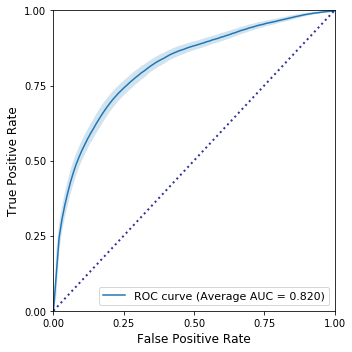

In [20]:
plt.figure(figsize=(5,5))
sns.lineplot(inter_fpr, inter_tpr,  ci=None, 
             label='ROC curve (Average AUC = %0.3f)' % np.mean(total_auc), 
             estimator='mean')
plt.fill_between(inter_fpr, inter_tpr-sd_tpr, inter_tpr+sd_tpr, alpha = 0.2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':',alpha = 0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.savefig('bootstrap_ROC.png',dpi=300, quality=100)

In [21]:
# bin Precision values to smooth PR curve
n_points = 100
precision_order =  np.flip(np.argsort(total_precision))
total_precision = total_precision[precision_order]
total_recall = total_recall[precision_order]
inter_recall = np.linspace(0, 1, n_points)
inter_precision = np.zeros(n_points)
sd_precision = np.zeros(n_points)
for i in range(n_points-1):
    inter_precision[i] = np.nanmean(total_precision[np.logical_and(total_recall > \
                                inter_recall[i], total_recall <= inter_recall[i+1])]) 
    sd_precision[i] = np.std(total_precision[np.logical_and(total_recall > \
                                inter_recall[i], total_recall <= inter_recall[i+1])])
inter_precision[n_points-1]=np.nan

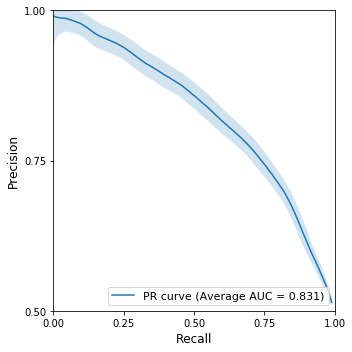

In [22]:
plt.figure(figsize=(5,5))
sns.lineplot(inter_recall, inter_precision, ci=None, 
              label='PR curve (Average AUC = %0.3f)' % np.mean(avg_precision),
             estimator=None)
plt.fill_between(inter_recall, inter_precision-sd_precision, 
                 inter_precision+sd_precision, alpha = 0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.0])
plt.yticks([0.5, 0.75, 1.0])
plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.savefig('bootstrap_PR.png',dpi=300, quality=100)

Finally, models based on the full data set were created and saved for further use.

In [23]:
rf_model.fit(full_data_df[['TF_ids',
                                'p_share','all_p','p_score',
                                'go_share','all_go','go_score', 
                                 'transfac', 'chea']].values,
                               full_data_df['label'].values)
dump(rf_model, 'rf_mod.joblib')

log_model = log_model.fit(full_data_df[['p_share','all_p','p_score', 
                                             'go_share','all_go', 'go_score',
                                             'transfac','chea','rf_score']].values,
                               full_data_df['label'].values)
dump(log_model, 'log_mod.joblib')

['log_mod.joblib']